# Capstone: Retrieving, Processing, and Visualizing Data with Python
Optional capstone project from the University of Michigan Python for Everybody course where you select, process, and visualize the data of your choice.


This project retrieves the COVID-19 death data from: <https://data.cdc.gov/NCHS/Provisional-COVID-19-Deaths-by-Sex-and-Age/9bhg-hcku>, stores the data into an SQLite database and creates some basic plots based on the data

####  Load libraries

In [1]:
import urllib.request
import urllib.error
import urllib.parse
import json
import ssl
import sqlite3
import calendar
import matplotlib.pyplot as plt
from datetime import datetime

#### Create database

In [2]:
conn = sqlite3.connect('covid19.sqlite')
cur = conn.cursor()

cur.execute('''
CREATE TABLE IF NOT EXISTS "covid_deaths" (
    "data_as_of"    TEXT,
    "start_date"	TEXT,
    "end_date"  TEXT,
    "grp"   TEXT,
    "year"   INTEGER,
    "month"   INTEGER,
    "state" TEXT,
    "sex"	TEXT,
    "age_group"	INTEGER,
    "covid_19_deaths"	INTEGER
);''')


#### Open URL and load data into python 

In [3]:
url = 'https://data.cdc.gov/resource/9bhg-hcku.json?'
parms = dict()
parms['$limit'] = 150000
url = url + urllib.parse.urlencode(parms)

# Ignore SSL certificate errors
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

print('Retrieving', url)
try:
    uh = urllib.request.urlopen(url, context=ctx)
    data = uh.read().decode()

except Exception as e:
    print(e)
    exit(1)

print('Retrieved', len(data), 'characters')
js = json.loads(data)

Retrieving https://data.cdc.gov/resource/9bhg-hcku.json?%24limit=150000
Retrieved 22121073 characters


#### Loop through data and update the database 

In [4]:
count = 0
for i in js:

    data_as_of = i.get('data_as_of')
    start_date = i.get('start_date')
    end_date = i.get('end_date')
    grp = i.get('group')
    year = i.get('year')
    month = i.get('month')
    state = i.get('state')
    sex = i.get('sex')
    age_group = i.get('age_group')
    covid_19_deaths = i.get('covid_19_deaths')

    cur.execute('''
        INSERT OR IGNORE INTO covid_deaths (data_as_of, start_date, end_date, 
        grp,year,month, state, sex, age_group, covid_19_deaths)
        VALUES (?,?,?,?,?,?,?,?,?,?) ''', (data_as_of, start_date, end_date, grp, year, month, state, sex, age_group, covid_19_deaths))
    count += 1
    conn.commit()

print("Added", count, "rows")

Added 50999 rows


#### Create Charts 

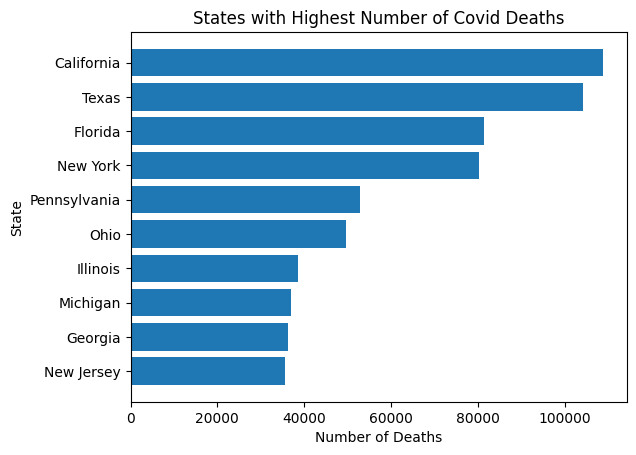

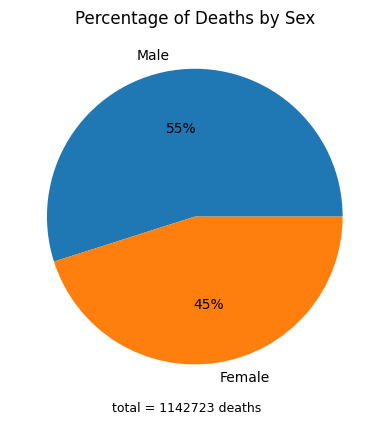

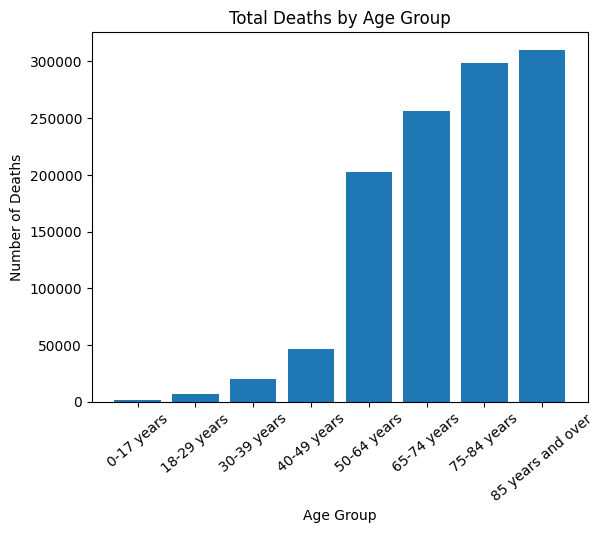

In [5]:
x = []
y = []

cur.execute('''
SELECT nested_query.state, SUM(nested_query.covid_19_deaths)
FROM (SELECT  CASE WHEN state = 'New York City' THEN 'New York' ELSE state END AS state ,covid_19_deaths
        FROM covid_deaths
        WHERE sex = 'All Sexes' AND age_group = 'All Ages' AND grp = 'By Total' AND state != 'United States'
        GROUP BY state ORDER BY covid_19_deaths DESC) as nested_query
GROUP BY nested_query.state
ORDER BY SUM(nested_query.covid_19_deaths ) DESC
LIMIT 10;
''')

for i in cur:
    x.append(i[0])
    y.append(i[1])

plt.barh(x, y)
plt.gca().invert_yaxis()
plt.title(label="States with Highest Number of Covid Deaths")
plt.xlabel('Number of Deaths')
plt.ylabel('State')
plt.show()

cur.execute('''
SELECT sex, covid_19_deaths
FROM covid_deaths
WHERE state = 'United States' and age_group = 'All Ages' and grp = 'By Total' 
''')
x.clear()
y.clear()
total_deaths  = cur.fetchone()[1]

for i in cur:
    y.append(i[0])
    x.append(i[1])

plt.pie(x, labels = y, autopct='%1.0f%%')
plt.title('Percentage of Deaths by Sex')
plt.figtext(0.5, 0.09, 'total = ' + str(total_deaths) + ' deaths', wrap=True, horizontalalignment='center', fontsize=9)
plt.show()

cur.execute('''
SELECT age_group , covid_19_deaths
FROM covid_deaths
WHERE state = 'United States'  AND grp = 'By Total' AND sex = 'All Sexes' AND age_group != 'All Ages'
AND age_group != 'Under 1 year' AND age_group != '1-4 years' AND age_group != '5-14 years' 
''')
c = 0
x.clear()
y.clear()
for i in cur:
    if c % 2 == 0 or c == 11:
        x.append(i[0])
        y.append(i[1])
    c += 1
plt.bar(x, y)
plt.xticks(rotation=40)
plt.title(label="Total Deaths by Age Group")
plt.ylabel('Number of Deaths')
plt.xlabel('Age Group')
plt.show()


#### Deaths by month and year

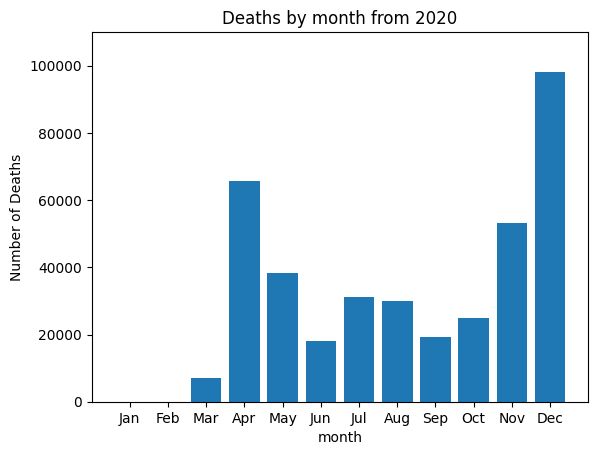

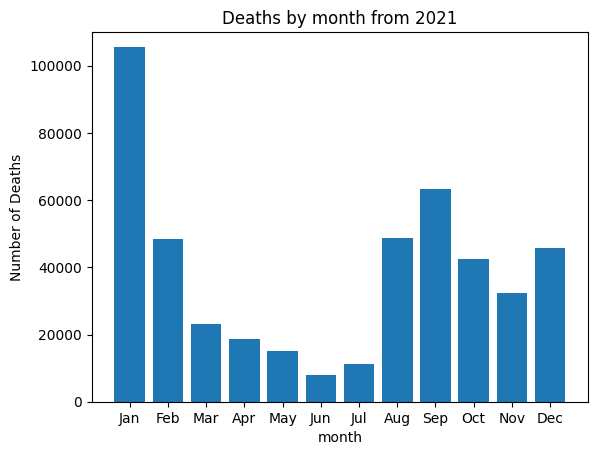

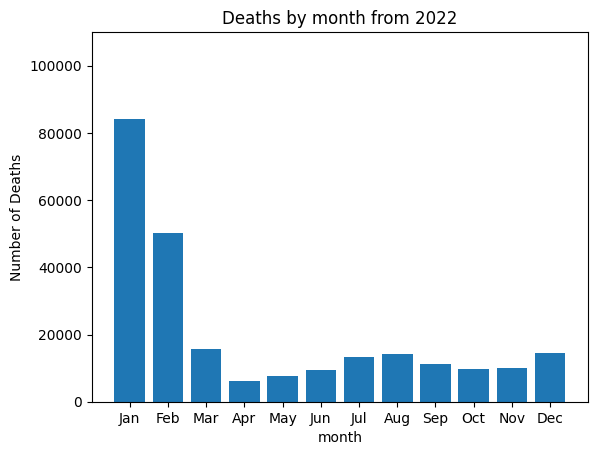

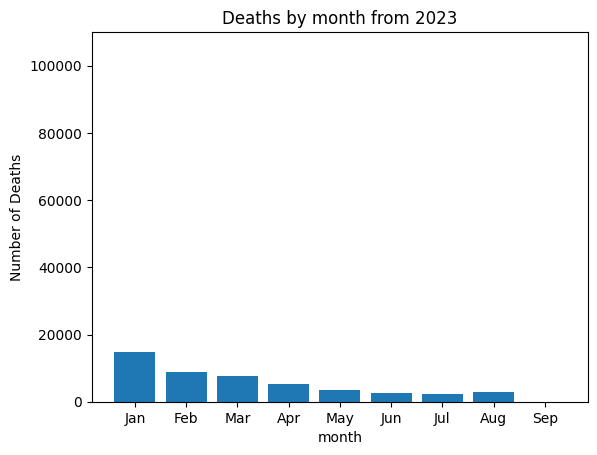

In [6]:
x.clear()
y.clear()
yr = []
xtemp = []
ytemp = []

currentMonth = datetime.now().month
currentYear = datetime.now().year

cur.execute('''
SELECT  year, month, sum(covid_19_deaths)
FROM covid_deaths
WHERE sex = 'All Sexes' AND age_group = 'All Ages' AND state = 'United States' AND grp = 'By Month' 
GROUP BY year, month
''')
for i in cur:
    xtemp.append(calendar.month_abbr[i[1]])
    ytemp.append(i[2])
    if i[1] == 12:
        x.append(xtemp.copy())
        y.append(ytemp.copy())
        yr.append(i[0])
        xtemp.clear()
        ytemp.clear()
        count = 0

if currentMonth < 12:      
    x.append(xtemp.copy())
    y.append(ytemp.copy())  
    yr.append(currentYear)

for i in range(len(x)):
    plt.bar(x[i], y[i])
    plt.title(label = "Deaths by month from " + str(yr[i]))
    plt.ylim(0, 110000)
    plt.ylabel('Number of Deaths')
    plt.xlabel('month')
    plt.show()       